This jupyter notebook provide a easy-to-follow tutorial to generate splits in a Sd-fashion, in which drugs within every fold will belong to specific scaffolds. 
We will use ClassyFire, a tool for automated chemical classification. 

In [43]:
import pandas as pd
import os
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import random
import itertools

We will use the DrugBank dataset for this tutorial, which we have made available in the tutorial folder of this repository

In [34]:
# Load the DTI network in the form of a 2-columns file.
drugbank_dtis = pd.read_csv(os.path.join('data','drugbank_dtis.tsv'),sep='\t', index_col=0)
drugbank_dtis

,Drug ID,Gene
0,DB00002,P08637
1,DB00002,P12314
2,DB00004,P31785
3,DB00005,P02747
4,DB00006,P00734
...,...,...
26414,DB16703,Q13464
26415,DB16703,O75116
26416,DB16703,P10632
26417,DB16733,Q9H2S1


In [35]:
# For this tutorial, we will load a generated pickle file that contains several chemical descriptors for 10k+ drugs
drugs_full = pd.read_pickle(os.path.join("data","drugs_annot_full.pkl"))
drugs_full

,PubChemID,kingdom,superclass,class,subclass
0,448781,Organic compounds,Benzenoids,Naphthalenes,Nitronaphthalenes
1,71655537,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,Hexacarboxylic acids and derivatives
2,44326982,Organic compounds,Organic oxygen compounds,Organooxygen compounds,Carbonyl compounds
3,446854,Organic compounds,Organic nitrogen compounds,Organonitrogen compounds,Amines
4,6323502,Organic compounds,"Nucleosides, nucleotides, and analogues",Nucleoside and nucleotide analogues,"2',3'-cyclic purine nucleoside phosphorothioates"
...,...,...,...,...,...
10151,138403682,None,None,None,None
10152,46936357,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"
10153,5938,Organic compounds,Organic nitrogen compounds,Organonitrogen compounds,Quaternary ammonium salts
10154,73353070,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"


Lets first plot the Superclass distribution

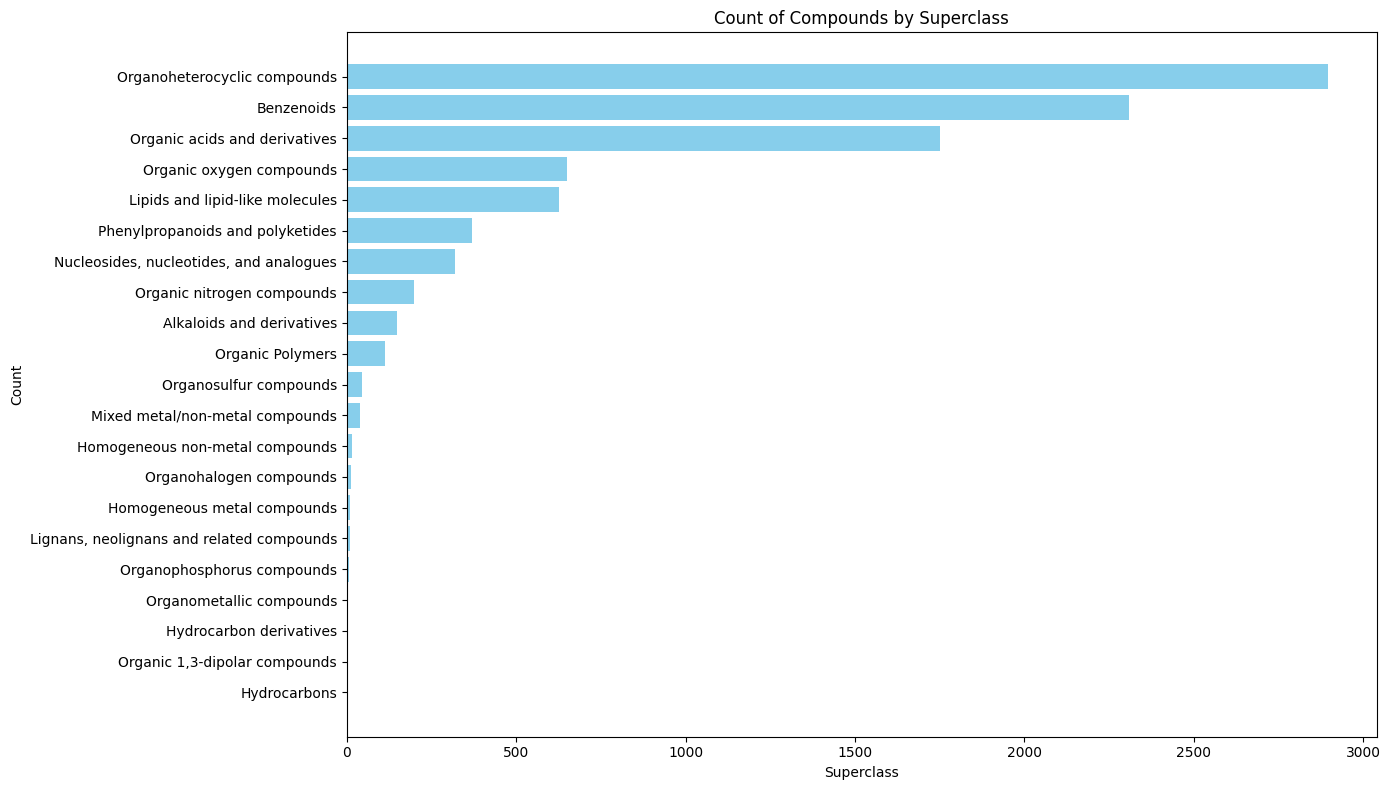

In [36]:
##drop nas and generate counter
drug_full_superclass = drugs_full['superclass'].dropna().reset_index(drop=True)
superclass_counter = Counter(drug_full_superclass)

# Prepare the data for plotting
superclass = [(k,v) for k,v in superclass_counter.items()]
sorted_superclass = sorted(superclass, key=lambda x:x[1], reverse=False)

# Create the bar plot
plt.figure(figsize=(14, 8))
plt.barh(list(map(lambda x: x[0], sorted_superclass)), list(map(lambda x: x[1], sorted_superclass)), color='skyblue')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.title('Count of Compounds by Superclass')
plt.tight_layout()


In this tutorial, we will keep the top 10 superclasses according to the number of compounts they have.

In [37]:
#keep the top 10
superclass = sorted(superclass, key=lambda x:x[1], reverse=True)[:10]

We will work with 2 dictionaries containing protein-to-aminoacid sequence mapping, and drug-to-smile sequence mapping, respectively. We have already generated pickle files for this purpose.

In [38]:
## load drug-smile dict
with open(os.path.join('data','smile_dict.pickle'), 'rb') as handle:
    smile_dict = pickle.load(handle)
    
## load protein-aa seq dict
with open(os.path.join('data','aa_dict.pickle'), 'rb') as handle:
    aa_dict = pickle.load(handle)

As Classyfire Drug ids are annotated usign PubChemID, we will first transform those IDs to DrugBank IDS. We have already generate a pickle dictionary for this purpose.

In [39]:
with open(os.path.join('data','cid_db_dict.pickle'), 'rb') as handle:
    cid_db_dict = pickle.load(handle)

We will know generate 1 fold for each superclass, so that the files can be used in a 10-fold CV fashion


In [42]:
def build_row(df):

        df_drugs, df_genes = df.iloc[:,0].values, df.iloc[:,1].values

        smiles_drugs = list(map(lambda x: smile_dict[x], df_drugs))
        aa_seq = list(map(lambda x: aa_dict[x], df_genes))

        df['SMILES'] = smiles_drugs
        df['Target Sequence'] = aa_seq

        return df

##init vars to store folds
folds_dict = {}
folds = []

#define seed and set of genes/proteins to be used
seed = 42
genes = set(drugbank_dtis.iloc[:,1].values)

for sclass in tqdm(superclass, desc = 'iterating super classes... for Sd'):
    
    sname = sclass[0]
    cids = list(map(lambda x: cid_db_dict.get(str(x), None), drugs_full[drugs_full['superclass'] == sname]['PubChemID'].values))
    cids = [x for x in cids if x]

    print(f"class {sname} - we are using {len(cids)}")

    #get all positive interactions with cids drugss
    pos_interactions_sclass = drugbank_dtis[drugbank_dtis.iloc[:,0].isin(cids)].reset_index(drop=True)
    sclass_drugs = set(pos_interactions_sclass.iloc[:,0].values)

    #subsample as many negatives as positive we have
    set_pos_interactions_sclass = set([tuple(x) for x in pos_interactions_sclass.values])
    random.seed(seed)
    neg_interactions = random.sample(set(itertools.product(sclass_drugs, genes)).difference(set_pos_interactions_sclass), pos_interactions_sclass.shape[0])
    
    #build pos and neg dataframes
    neg_interactions_sclass = pd.DataFrame(neg_interactions)
    neg_interactions_sclass.columns = ['Drug ID', 'Gene']
    pos_interactions_sclass['Label'] = 1
    neg_interactions_sclass['Label'] = 0

    #build a dataframe
    sclass_df = build_row(pd.concat([pos_interactions_sclass, neg_interactions_sclass]))
    sclass_df = sclass_df.sample(frac=1, random_state=seed)
    folds_dict[sname] = sclass_df
    folds.append(sclass_df)

iterating super classes... for Sd:   0%|          | 0/10 [00:00<?, ?it/s]

class Organoheterocyclic compounds - we are using 1999


iterating super classes... for Sd:  10%|█         | 1/10 [00:06<00:59,  6.66s/it]

class Benzenoids - we are using 1569


iterating super classes... for Sd:  20%|██        | 2/10 [00:11<00:45,  5.68s/it]

class Organic acids and derivatives - we are using 1239


iterating super classes... for Sd:  30%|███       | 3/10 [00:15<00:34,  4.93s/it]

class Organic oxygen compounds - we are using 545


iterating super classes... for Sd:  40%|████      | 4/10 [00:17<00:21,  3.65s/it]

class Lipids and lipid-like molecules - we are using 523


iterating super classes... for Sd:  50%|█████     | 5/10 [00:18<00:14,  2.91s/it]

class Phenylpropanoids and polyketides - we are using 272


iterating super classes... for Sd:  60%|██████    | 6/10 [00:19<00:08,  2.18s/it]

class Nucleosides, nucleotides, and analogues - we are using 304


iterating super classes... for Sd: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]

class Organic nitrogen compounds - we are using 157
class Alkaloids and derivatives - we are using 78
class Organic Polymers - we are using 26


Lets check if they accomplish Sd requirements, i.e., every drug in each fold does not appear in any other fold

In [41]:
## check Sd
for i in range(len(folds)):
    train_drugs = set(pd.concat(folds[:i] + folds[i+1:])['Drug ID'])
    test_drugs = set(folds[i]['Drug ID'])
    assert train_drugs.intersection(test_drugs) == set()
    print(f"fold {i} - Sd accomplish!")

fold 0 - Sd accomplish!
fold 1 - Sd accomplish!
fold 2 - Sd accomplish!
fold 3 - Sd accomplish!
fold 4 - Sd accomplish!
fold 5 - Sd accomplish!
fold 6 - Sd accomplish!
fold 7 - Sd accomplish!
fold 8 - Sd accomplish!
fold 9 - Sd accomplish!


Everything looks good, now we can save these folds. For every fold, 3 (train, val, test) .csv files will be generated.
The test will contain interactions where drugs accomplish Sd constraints, and only belong to a single Superclass category.

In [46]:
#create folder
seed_fpath = os.path.join('data','SplitsClassyfire_DrugBank',f'seed_{seed}')
if not os.path.exists(seed_fpath):
    os.makedirs(seed_fpath)

#then folds
info = []
for i in range(len(folds)):
    
    #
    info.append((i, superclass[i][0], folds[i].shape[0]))

    #create folder
    fold_fpath = os.path.join(seed_fpath, f'fold{i}')
    if not os.path.exists(fold_fpath):
        os.makedirs(fold_fpath)

    #create train val and test
    train_drugs = pd.concat(folds[:i] + folds[i+1:]).reset_index(drop=True)
    test_drugs = folds[i].reset_index(drop=True)
    train_drugs, val_drugs = train_test_split(train_drugs, test_size = 0.2)

    ##save it
    train_drugs.to_csv(os.path.join(fold_fpath, 'train.csv'))
    val_drugs.to_csv(os.path.join(fold_fpath, 'val.csv'))
    test_drugs.to_csv(os.path.join(fold_fpath, 'test.csv'))

#build info dataframe and save it
info_df = pd.DataFrame(info)
info_df.columns = ['fold','superclass', '#edges']
info_df.to_csv(os.path.join('data','SplitsClassyfire_DrugBank', 'info.tsv'),sep='\t')

These folds can be easily run by some of the inductive methods evaluated in the paper, such as Moltrans or HyperAttentionDTI. 
For instance, you can run Moltrans on these folds using the following commands: